# Simplified Direct Sampling aka Direct Sampling Best Candidate (DSBC)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from geone import img
from geone import imgplot
from geone import deesseinterface

import copy

In [2]:
%load_ext autoreload
%autoreload 1
%aimport ensemble, simulator, scoring, tsanfleuron, mpstool

## Test 2. Continuous without pyramides.

In [3]:
bedmap = np.loadtxt('clip_ti_2011.txt')
ti = img.Img(nx=bedmap.shape[1], ny=bedmap.shape[0], nz=1, nv=1, sx=1, sy=1, sz=1, ox=0, val=bedmap[np.newaxis, np.newaxis])

In [4]:
np.nanmin(ti.val)

2126.084229

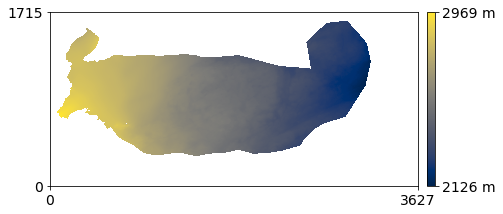

In [66]:
plt.figure(figsize=(2*3.54330709,3.54330709))
imgplot.drawImage2D(ti,
                categ=False,
                cmap='cividis',
                cticks=[2126, 2969],
                cticklabels=['2126 m', '2969 m'],
                vmin=2126,
                vmax=2969,
                cticklabels_fontsize=14,
                xticklabels_fontsize=14,
                yticklabels_fontsize=14,
                xticks=[0,ti.nx],
                yticks=[0,ti.ny],
                #title='TI',
                title_fontsize=14,
               )
plt.tight_layout()
plt.savefig(f'figures/tsanfleuron-ti.pdf', dpi=300)

In [67]:
simulator_ds = tsanfleuron.TsanfleuronDS('test/test', nneighboringNode=8,
                                  distanceThreshold=0.002,
                                  maxScanFraction=0.005,
                                 ox=1200, oy=500, nx=200, ny=200)

In [68]:
simulator_dsbc = tsanfleuron.TsanfleuronDSBC('test/testdsbc', nneighboringNode=16,
                                  distanceThreshold=0,
                                  maxScanFraction=0.0005,
                                 ox=1200, oy=500, nx=200, ny=200)

In [94]:
#plt.figure(figsize=(15,15))
#imgplot.drawImage2D(simulator.cut_ti(ti), cmap='magma')

In [95]:
deesse_input_ds = simulator_ds.deesse_input(ti, 40, 40, 444)
output_ds = deesseinterface.deesseRun(deesse_input_ds, 40)

Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete

Warnings encountered (1 times in all):
#  1: WARNING 00010: a variable in a training image is not exhaustively informed


In [96]:
deesse_input_dsbc = simulator_dsbc.deesse_input(ti, 40, 40, 444)
output_dsbc = deesseinterface.deesseRun(deesse_input_dsbc, 40)

Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete

Warnings encountered (1 times in all):
#  1: WARNING 00010: a variable in a training image is not exhaustively informed


In [72]:
def restrict(image):
    new_image = copy.deepcopy(image)
    new_image.resize(ix0=100, ix1=300, iy0=100, iy1=300)
    return new_image

In [139]:
def plot_tsanfleuron_example(image, title, vmin, vmax, cmap='cividis'):
    plt.figure(figsize=(3.54330709,3.54330709))
    imgplot.drawImage2D(restrict(image),
                    cmap=cmap,
                    cticks=[vmin,vmax],
                    cticklabels=[f'{vmin} m', f'{vmax} m'],
                    vmin=vmin, vmax=vmax,
                    cticklabels_fontsize=14,
                    xaxis=False,
                    yaxis=False,
                    title=title,
                    title_fontsize=14
                   )
    plt.tight_layout()
    plt.savefig(f'figures/tsanfleuron-{title}.pdf', dpi=300)

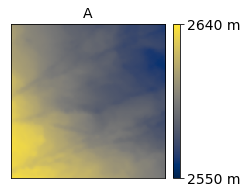

In [140]:
plot_tsanfleuron_example(simulator_ds.im_ref_with_sim(ti), 'A', 2550, 2640)

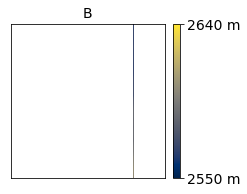

In [141]:
plot_tsanfleuron_example(simulator_ds.sim_grid(ti), 'B', 2550, 2640)

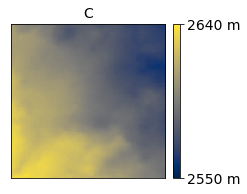

In [142]:
plot_tsanfleuron_example(output_ds['sim'][0], 'C', 2550, 2640)

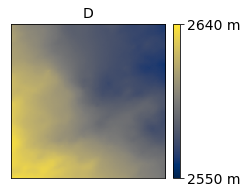

In [143]:
plot_tsanfleuron_example(output_dsbc['sim'][0], 'D', 2550, 2640)

In [144]:
import properscoring
def crps_map(true_ref, list_sim):
    e = np.stack([list_sim[x].val[0,0] for x in range(40)], axis=-1)
    t = true_ref.val[0,0]
    return properscoring.crps_ensemble(t,e)

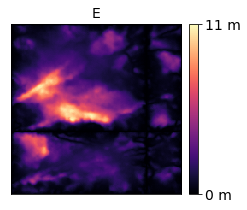

In [145]:
diff_ds = copy.deepcopy(output_ds['sim'][0])
diff_ds.val[0,0] = crps_map(simulator_ds.im_ref_with_sim(ti),
                       output_ds['sim'])
plot_tsanfleuron_example(diff_ds, 'E', 0, 11, cmap='magma')

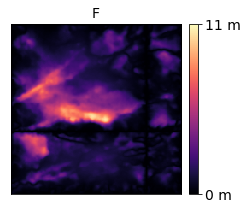

In [146]:
diff_dsbc = copy.deepcopy(output_dsbc['sim'][0])
diff_dsbc.val[0,0] = crps_map(simulator_dsbc.im_ref_with_sim(ti),
                       output_dsbc['sim'])
plot_tsanfleuron_example(diff_dsbc, 'F', 0, 11, cmap='magma')

In [19]:
locations = [(1200, 500),
             (800, 500),
             (1700, 600),
             (2600, 800),
             (1900, 900),
             (2200, 700),
             (1000, 900),
             (500,  800),
             (2700, 1200),
             (1500, 1000)
             ]

In [20]:
def ds_simulation_parameters(ox, oy):
    parameter_sets = [ [n, i] for n in [8, 16, 32, 64] for i in [0.001, 0.002, 0.005, 0.01]]

    df = pd.DataFrame(parameter_sets, columns = ['nneighboringNode', 'distanceThreshold'])
    df['maxScanFraction'] = 0.005
    df['ox'] = ox
    df['oy'] = oy
    return df

In [21]:
def generate_df(locations, parameter_function):
    return pd.concat([parameter_function(ox, oy)
           for ox, oy in locations],
          ignore_index=True)

In [22]:
df_ds = generate_df(locations, ds_simulation_parameters)

In [23]:
def MVE(ensemble, true):
    return scoring.crps_pointwise(ensemble, true.val[0,0], lambda x:np.mean(x))

def MPE(ensemble, true):
    return np.mean(scoring.crps_pointwise(ensemble, true.val[0,0], lambda x:x))

In [24]:
def load_ensembles(row, simulator_class):
    ox = int(row['ox'])
    oy = int(row['oy'])
    simulator_obj = simulator_class(
                 nneighboringNode=row['nneighboringNode'],
                 distanceThreshold=row['distanceThreshold'],
                 maxScanFraction=row['maxScanFraction'],
                 root_dir=f'case2B/ds-{ox}-{oy}/',
                 ox=ox,
                 oy=oy)
    
    ensemble, timing = simulator_obj.get_ensemble(ti,
                                                  ensemble_size=40,
                                                  nthreads=40,
                                                  seed=444,
                                                  overwrite=True,
                                                  dtype='float')
    true = simulator_obj.im_ref(ti)
    
    
    
    row['timing'] = timing
    row['ensemble_size'] = len(ensemble)
    for function in (MPE, MVE):
        row[f'crps_{function.__name__}'] = function(ensemble, true)
    
    
    
    return row

In [25]:
df_ds = df_ds.apply(lambda row: load_ensembles(row, tsanfleuron.TsanfleuronDS), axis=1)
df_ds

,nneighboringNode,distanceThreshold,maxScanFraction,ox,oy,timing,ensemble_size,crps_MPE,crps_MVE
0,8.0,0.001,0.005,1200.0,500.0,49.737684,40.0,2.043068,0.790142
1,8.0,0.002,0.005,1200.0,500.0,45.249641,40.0,1.988947,0.655207
2,8.0,0.005,0.005,1200.0,500.0,43.274896,40.0,1.984827,0.776107
3,8.0,0.010,0.005,1200.0,500.0,42.593153,40.0,1.863662,0.690317
4,16.0,0.001,0.005,1200.0,500.0,71.658427,40.0,1.866128,0.599168
...,...,...,...,...,...,...,...,...,...
155,32.0,0.010,0.005,1500.0,1000.0,54.878859,40.0,2.254213,1.646975
156,64.0,0.001,0.005,1500.0,1000.0,303.166465,40.0,2.076583,1.026815
157,64.0,0.002,0.005,1500.0,1000.0,175.007496,40.0,2.259521,1.403330
158,64.0,0.005,0.005,1500.0,1000.0,89.401636,40.0,2.428452,1.646657


In [26]:
def dsbc_simulation_parameters(ox, oy):
    parameter_sets = [ [n, f] for n in [8, 16, 32, 64] 
                      for f in [0.001, 0.0005, 0.0002, 0.0001]]

    df = pd.DataFrame(parameter_sets, columns=['nneighboringNode','maxScanFraction'])
    df['distanceThreshold'] = 0
    df['ox'] = ox
    df['oy'] = oy
    return df

In [27]:
df_dsbc = generate_df(locations, dsbc_simulation_parameters)

In [176]:
df_dsbc = df_dsbc.apply(lambda row:
                            load_ensembles(row,
                                tsanfleuron.TsanfleuronDSBC),
                        axis=1)
df_dsbc

,nneighboringNode,maxScanFraction,distanceThreshold,ox,oy,timing,ensemble_size,crps_MPE,crps_MVE
0,8.0,0.0010,0.0,1200.0,500.0,100.608428,40.0,1.758052,0.722566
1,8.0,0.0005,0.0,1200.0,500.0,72.171379,40.0,1.734936,0.638669
2,8.0,0.0002,0.0,1200.0,500.0,85.104975,40.0,1.773520,0.575735
3,8.0,0.0001,0.0,1200.0,500.0,87.013911,40.0,1.785664,0.554003
4,16.0,0.0010,0.0,1200.0,500.0,108.771865,40.0,1.595565,0.582820
...,...,...,...,...,...,...,...,...,...
155,32.0,0.0001,0.0,1500.0,1000.0,115.334787,40.0,2.080058,1.306113
156,64.0,0.0010,0.0,1500.0,1000.0,193.897180,40.0,2.098856,1.128810
157,64.0,0.0005,0.0,1500.0,1000.0,127.156422,40.0,2.157514,1.172743
158,64.0,0.0002,0.0,1500.0,1000.0,103.413357,40.0,2.161242,1.159584


In [177]:
# global comparison without std
df_compare_ds = df_ds.groupby(['nneighboringNode','maxScanFraction', 'distanceThreshold']).agg(
    {
        'crps_MPE' : np.mean,
        'crps_MVE' : np.mean,
        'timing' : np.mean,
                                                                                       }).reset_index()
df_compare_ds.head()

,nneighboringNode,maxScanFraction,distanceThreshold,crps_MPE,crps_MVE,timing
0,8.0,0.005,0.001,1.794823,0.694145,52.519002
1,8.0,0.005,0.002,1.763774,0.643601,47.609415
2,8.0,0.005,0.005,1.801827,0.666880,45.081211
3,8.0,0.005,0.010,1.773325,0.652152,44.297453
4,16.0,0.005,0.001,1.718144,0.683572,72.342257


In [178]:
plot_df_ds = df_compare_ds.sort_values(by='crps_MVE').copy()
plot_df_ds.head()

,nneighboringNode,maxScanFraction,distanceThreshold,crps_MPE,crps_MVE,timing
1,8.0,0.005,0.002,1.763774,0.643601,47.609415
3,8.0,0.005,0.010,1.773325,0.652152,44.297453
2,8.0,0.005,0.005,1.801827,0.666880,45.081211
8,32.0,0.005,0.001,1.695638,0.673086,115.810322
6,16.0,0.005,0.005,1.771346,0.675036,47.911644


In [179]:
plot_df_ds['timing'] = np.round(plot_df_ds['timing']/40, 1)
plot_df_ds['crps_MPE'] = np.round(plot_df_ds['crps_MPE'], 2)
plot_df_ds['crps_MVE'] = np.round(plot_df_ds['crps_MVE'], 2)
plot_df_ds['nneighboringNode'] = plot_df_ds['nneighboringNode'].map(lambda x: int(x))
plot_df_ds.to_latex('figures/tsanfleuron-table-ds.tex', index=False)

In [180]:
# global comparison without std
df_compare_dsbc = df_dsbc.groupby(['nneighboringNode','maxScanFraction', 'distanceThreshold']).agg({'crps_MPE' : np.mean,
                                                                                        'crps_MVE' : np.mean,
                                                                                                    
                                                                                                'timing' : np.mean
                                                                                       }).reset_index()
plot_df_dsbc = df_compare_dsbc.sort_values(by='crps_MVE').copy()
plot_df_dsbc.head()

,nneighboringNode,maxScanFraction,distanceThreshold,crps_MPE,crps_MVE,timing
6,16.0,0.0005,0.0,1.584470,0.579769,88.758901
5,16.0,0.0002,0.0,1.591174,0.583380,87.238723
7,16.0,0.0010,0.0,1.581502,0.591247,117.618481
11,32.0,0.0010,0.0,1.605726,0.605138,127.796988
3,8.0,0.0010,0.0,1.658981,0.612094,105.828847


In [181]:
plot_df_dsbc['timing'] = np.round(plot_df_dsbc['timing']/40,1)
plot_df_dsbc['crps_MPE'] = np.round(plot_df_dsbc['crps_MPE'], 2)
plot_df_dsbc['crps_MVE'] = np.round(plot_df_dsbc['crps_MVE'], 2)
plot_df_dsbc['nneighboringNode'] = plot_df_dsbc['nneighboringNode'].map(lambda x: int(x))
plot_df_dsbc.drop(columns=['distanceThreshold'], inplace=True)
plot_df_dsbc.to_latex('figures/tsanfleuron-table-dsbc.tex', index=False)

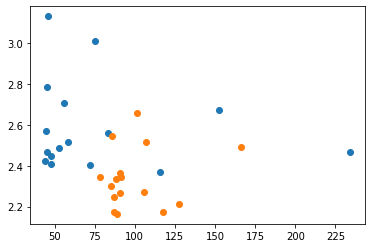

In [182]:
plt.scatter(x=df_compare_ds['timing'], y=df_compare_ds['crps_MPE']+df_compare_ds['crps_MVE'])
plt.scatter(x=df_compare_dsbc['timing'], y=df_compare_dsbc['crps_MPE']+df_compare_dsbc['crps_MVE'])

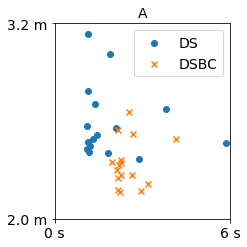

In [183]:
fig, ax = plt.subplots(figsize=(3.54330709,3.54330709))
ax.scatter(x=df_compare_ds['timing']/40, y=df_compare_ds['crps_MPE']+df_compare_ds['crps_MVE'])
ax.scatter(x=df_compare_dsbc['timing']/40, y=df_compare_dsbc['crps_MPE']+df_compare_dsbc['crps_MVE'], marker='x')
ax.set(xlim=[0,6], ylim=[2,3.2])
ax.set_xticks([0,6])
ax.set_yticks([2,3.2])
ax.set_xticklabels(['0 s','6 s'], fontsize=14)
ax.set_yticklabels(['2.0 m','3.2 m'], fontsize=14)
ax.legend(['DS', 'DSBC'], fontsize=14)
ax.set_title('A', fontsize=14)
fig.tight_layout()
fig.savefig(f'figures/tsanfleuron-scatter.pdf', dpi=300)


    

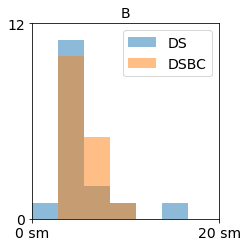

In [184]:
fig, ax = plt.subplots(figsize=(3.54330709,3.54330709))
ax.hist((df_compare_ds['crps_MPE']+df_compare_ds['crps_MVE'])*df_compare_ds['timing']/40, bins=np.linspace(0,25,10), alpha=0.5)
ax.hist((df_compare_dsbc['crps_MPE']+df_compare_dsbc['crps_MVE'])*df_compare_dsbc['timing']/40, bins=np.linspace(0,25,10), alpha=0.5)
ax.set(xlim=[0,20], ylim=[0, 12])
ax.set_xticks([0,20])
ax.set_yticks([0, 12])
ax.set_xticklabels(['0 sm','20 sm'], fontsize=14)
ax.set_yticklabels(['0','12'], fontsize=14)
ax.legend(['DS', 'DSBC'], fontsize=14)
ax.set_title('B', fontsize=14)
fig.tight_layout()
fig.savefig(f'figures/tsanfleuron-histogram.pdf', dpi=300)